# IRM on Bike Sharing daily dataset

Trying another classic machine learning dateset, the UCI ML repository [Bike Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset).

For IRM to work, we need to be able to define several _environments_ on which to train. An environment is the result of an intervention - something that changed the data generating process. The environments need to be sufficiently different (and sufficiently similar). Then IRM will return to us an invariant representation - one that has learned the correlations that hold true across environments, but ignored spurious correlations specific to an environment.

In this case, we could try season as the environment. The season may be strongly correlated with bike sharing, but it seems more likely that the effects of the season - the temperature, humidity and wind etc - are actually causal of fewer people biking.

In [235]:
import pandas as pd

import torch

from torch import nn, optim, autograd
from torch.nn import functional as F

Let's try on the daily data first. We can return to hourly.

In [236]:
df = pd.read_csv('../../data/Bike-Sharing-Dataset/day.csv')

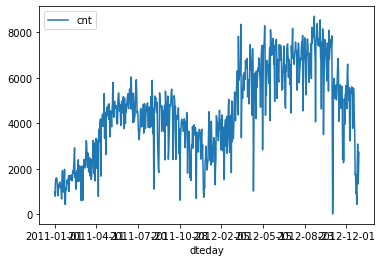

In [237]:
df.plot(x='dteday', y='cnt', kind='line')

In [238]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


A little feature engineering.

In [299]:
day_dummies = pd.get_dummies(df['weekday'])
day_dummies.columns = ['sun', 'mon', 'tues', 'wed', 'thurs', 'fri', 'sat']
day_dummies.head()

,sun,mon,tues,wed,thurs,fri,sat
0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0


In [300]:
weather_dummies = pd.get_dummies(df['weathersit'], drop_first=True)
weather_dummies.columns = ['misty', 'rainy']
weather_dummies.head()

,misty,rainy
0,1,0
1,1,0
2,0,0
3,0,0
4,0,0


In [301]:
features = [
    'holiday', 'workingday',
    'sun', 'mon', 'tues', 'wed', 'thurs', 'fri', 'sat',
    'misty', 'rainy',
    'temp', 'atemp', 'hum', 'windspeed'
]

In [302]:
environment = ['season']

In [303]:
target = ['cnt']

In [304]:
df_ = (
    df
    .merge(weather_dummies, left_index=True, right_index=True)
    .merge(day_dummies, left_index=True, right_index=True)
    [features + environment + target]
)

Since during IRM we'll be training on several environments, we wrap each in a dict for easy management.

In [306]:
def construct_env(df):
    return {
        'features': torch.Tensor(
            df.drop(environment + target,
                    axis='columns')
              .to_numpy()
        ),
        'target': torch.Tensor(df['cnt'].to_numpy()).unsqueeze(dim=1)
    }

Define our neural net architecture. We're starting with a straightforward MLP with ReLU nonlinearities and a sigmoid output, since it's a classification problem.

In [307]:
class NN(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super(NN, self).__init__()
        self.layer1 = nn.Linear(n_features, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

Define a bunch of utility functions for calculating errors and such to report during training.

In [308]:
mse = nn.MSELoss(reduction='mean')

In [309]:
def penalty(predictions, targets):
    dummy = torch.tensor(1., requires_grad=True)
    loss = mse(predictions*dummy, targets)
    grad = autograd.grad(loss, [dummy], create_graph=True)[0]
    squared_grad_norm = (grad**2).sum()
    return squared_grad_norm

Construct environments. We'll take seasons to be the environments. 1 - winter, 2 - spring, 3 - summer, 4 - fall.

To start a new training procedure, we need to run all the code below here, since the environments are mutable dictionaries that pick up entries during training.

In [341]:
env_test = construct_env(df_[df_.season == 1])
env_valid = construct_env(df_[df_.season == 4])
env_1 = construct_env(df_[df_.season == 2])
env_2 = construct_env(df_[df_.season == 3])

In [342]:
len(env_test['target']), len(env_valid['target']), len(env_1['target']), len(env_2['target'])

(181, 178, 184, 188)

In [343]:
N_FEATURES = env_1['features'].shape[1]
HIDDEN_DIM = 100

In [344]:
net = NN(N_FEATURES, HIDDEN_DIM)

In [345]:
opt = optim.Adam(net.parameters(), lr=1e-3)

In [346]:
for iteration in range(20001):
    for env in [env_1, env_2]:
        preds = net(env['features'])
        env['error'] = mse(preds, env['target'])
        env['penalty'] = penalty(preds, env['target'])
    
    train_error = torch.stack([env_1['error'], env_2['error']]).mean()
    train_penalty = torch.stack([env_1['penalty'], env_2['penalty']]).mean()
    
    # deactivate IRM to begin
    
#     total_loss = train_error

    # delayed introduction of IRM penalty (or hard to start learning)
    if iteration < 1000:
        total_loss = train_error
    else:
        total_loss = (1e-2 * train_error + train_penalty)
        
    opt.zero_grad()
    total_loss.backward()
    opt.step()
    
    valid_preds = net(env_valid['features'])
    env_1_preds = net(env_1['features'])
    env_2_preds = net(env_2['features'])
    
    # ## train environment metrics
    env_1['mse'] = mse(env_1_preds, env_1['target'])
    env_2['mse'] = mse(env_2_preds, env_2['target'])
    
    # ## validation set metrics
    env_valid['mse'] = mse(valid_preds, env_valid['target'])
    
    if iteration % 1000 == 0:
        print('---')
        print('iteration: {}, train_loss: {:.8f}'.format(iteration, total_loss))
        print('env_1 mse: {:.3f}'.format(env_1['mse']))
        print('env_2 mse: {:.3f}'.format(env_2['mse']))
        print('env_valid mse: {:.3f}'.format(env_valid['mse']))

---
iteration: 0, train_loss: 30881258.00000000
env_1 mse: 27783916.000
env_2 mse: 33977604.000
env_valid mse: 25227856.000
---
iteration: 1000, train_loss: 1967556657152.00000000
env_1 mse: 2529671.750
env_2 mse: 2162281.750
env_valid mse: 2422413.750
---
iteration: 2000, train_loss: 21603.96679688
env_1 mse: 2089337.875
env_2 mse: 2222251.250
env_valid mse: 2354120.000
---
iteration: 3000, train_loss: 21604.01171875
env_1 mse: 2089338.625
env_2 mse: 2222251.500
env_valid mse: 2354119.250
---
iteration: 4000, train_loss: 21557.96093750
env_1 mse: 2089338.125
env_2 mse: 2222251.750
env_valid mse: 2354119.750
---
iteration: 5000, train_loss: 21557.96093750
env_1 mse: 2089338.125
env_2 mse: 2222251.750
env_valid mse: 2354120.000


KeyboardInterrupt: 

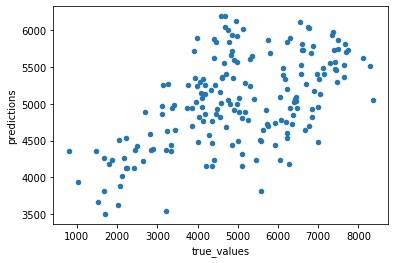

In [347]:
(
    pd.DataFrame({
        'predictions': net(env_1['features']).squeeze().tolist(),
        'true_values': env_1['target'].squeeze().tolist()
    }).plot(x='true_values', y='predictions', kind='scatter')
)

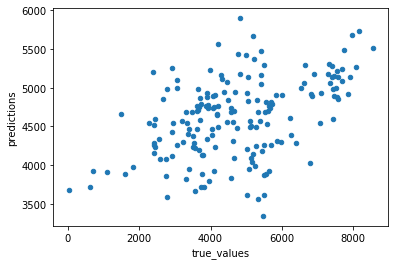

In [348]:
(
    pd.DataFrame({
        'predictions': net(env_valid['features']).squeeze().tolist(),
        'true_values': env_valid['target'].squeeze().tolist()
    }).plot(x='true_values', y='predictions', kind='scatter')
)

In [270]:
mse(net(env_test['features']), env_test['target']).item()

3167779.75